# Sleep vs. School

Lucy Turner

Quantified Self: Final Project for Gonzaga CPSC 222, Spring 2022

## Introduction

For the first dataset, we will be working with health data from a [Whoop fitness tracker](https://www.whoop.com).

The Whoop health dataset contains the following attributes: 
* date
* Strain Score
* Avg Heart Rate - Beats / min
* Heart Rate Variability - Milliseconds
* Max Heart Rate - Beats / min
* Resting Heart Rate - Beats / min
* Total Calories Burned - Calories
* Recovery Score - %
* Deep Sleep - Hours
* Deep Sleep Percent - %
* Light Sleep - Hours
* Light Sleep Percent - %
* Nap Count - Naps
* Nap Sleep - Hours
* REM Sleep - Hours
* REM Sleep Percent - %
* Sleep End Time - 24-hour time
* Sleep Score - %
* Sleep Start Time - 24-hour time
* Time Awake - Hours
* Time in Bed - Hours
* Total Sleep - Hours
* Sleep Consistency - %
* Sleep Cycles - Cycles
* Sleep Disturbances - Disturbances
* Sleep Disturbances / Hour - Disturbances
* Sleep Disturbances Duration - Minutes
* Sleep Onset Latency - Minutes
* Sleep Respiratory Rate - Breaths / min
* Time Asleep Percent - %
* Time Awake Percent - %

The attributes fall under the following categories:  
Activity,Heart,Heart,Heart,Heart,Metabolism,Recovery,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Length,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality,Sleep Quality

The Assignments dataset contains:
* Date
* Assignments

From this data, once joined with the health data, I will create the additional columns "Number of Assignments", "Day of the Week", and "Weekday"

## Data Analysis

### Cleaning

The first step was to load the data from both csv files into [pandas DataFrame objects](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html?highlight=dataframe#pandas.DataFrame). We did this using [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html?highlight=read_csv#pandas.read_csv)

In [24]:
import pandas as pd
import utils as u
whoop_df = pd.read_csv('raw_health_data.csv', index_col=0)
assignments_df = pd.read_csv('assignments_by_date.csv')

##### Woop Data Cleaning

To clean this data, we will use DataFrame method [pandas.DataFrame.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html?highlight=interpolate#pandas.DataFrame.interpolate) to fill middle values that are missing, or NaN. We used `ffill()` and `bfill()`, forwards and backwards fill methods of [pandas.DataFrame.fillna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) to ensure that no end values are missed.

In [25]:
whoop_df.interpolate(method='linear', inplace=True)
whoop_df.fillna(method='ffill', inplace=True)
whoop_df.fillna(method='bfill', inplace=True)

Looking at the resulting DataFrame, we decided that we wanted to focus only on sleep data in connection to assignments for the semester, so for this project we will only be working with sleep and assignment data from 1/11/22.

We will form a new DataFrame that only includes the columns in `whoop_df` that we want to continue working with. 

These columns are:
* Deep Sleep - Hours
* Deep Sleep Percent - %
* Light Sleep - Hours
* Light Sleep Percent - %
* Nap Count - Naps
* Nap Sleep - Hours
* REM Sleep - Hours
* REM Sleep Percent - %

We call `.loc['2022-01-11':]` on the resulting DataFrame to obtain the slice of data in the correct date range.

Finally, we convert the index column to a pandas datetime object using [pandas.to_datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html?highlight=to_datetime#pandas.to_datetime).

In [26]:
sleep_hw_df = whoop_df.drop(columns=['Strain Score', 'Avg Heart Rate', 'Heart Rate Variability', 'Max Heart Rate', 'Resting Heart Rate', 'Total Calories Burned',
       'Recovery Score', 'Sleep End Time', 'Sleep Score', 'Sleep Start Time', 'Time Awake', 'Time in Bed',
       'Sleep Consistency', 'Sleep Cycles', 'Sleep Disturbances', 'Sleep Disturbances / Hour', 'Sleep Disturbances Duration', 
       'Sleep Onset Latency', 'Sleep Respiratory Rate', 'Time Asleep Percent', 'Time Awake Percent']).loc['2022-01-11':]
sleep_hw_df.index = pd.to_datetime(sleep_hw_df.index)
print(sleep_hw_df)

            Deep Sleep  Deep Sleep Percent  Light Sleep  Light Sleep Percent  \
date                                                                           
2022-01-11    1.093341           15.186658     5.727659            79.557996   
2022-01-12    0.916865           14.871207     3.689389            59.840494   
2022-01-13    0.965797           15.339545     4.246074            67.439501   
2022-01-14    1.497095           21.034635     4.390751            61.691359   
2022-01-15    0.748144           12.801974     4.380313            74.954344   
2022-01-16    0.803762           11.334004     4.744484            66.902886   
2022-01-17    1.159650           18.815634     3.119309            50.611646   
2022-01-18    0.916866           18.131365     2.982159            58.973290   
2022-01-19    0.153211            2.845344     4.644224            86.249883   
2022-01-20    1.494956           25.020212     2.395233            40.087628   
2022-01-21    0.900558           14.3956

##### Assignments Data Cleaning

To clean the Assignments data, we converted the "Date" column to a pandas datetime object using `pd.to_datetime()`. See to_datetime documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html). The resulting DataFrame has a numerical index because the 'Date' column contains duplicate dates on days where there are multiple assignments due. The "Assignments" column contained the name of every assignment that was due, which is not helpful in a classification model. To fix these issues and add a "Number of Assignments" column instead of a string assignment name column, we created a dictionary containing the number of assignments by date, and converted this dictionary to a new DataFrame. 

In [27]:
assignments_df['Date'] = pd.to_datetime(assignments_df['Date'])
num_assignments = {}
for date, dates in assignments_df.groupby('Date'):
    num_assignments[date] = dates['Assignments'].count()
num_ass_df = pd.DataFrame.from_dict(num_assignments, orient='index', columns=['Number of Assignments'])
print(num_ass_df)

            Number of Assignments
2022-01-11                      1
2022-01-13                      1
2022-01-16                      1
2022-01-18                      3
2022-01-20                      3
2022-01-23                      1
2022-01-24                      1
2022-01-25                      3
2022-01-27                      2
2022-01-30                      1
2022-01-31                      1
2022-02-01                      3
2022-02-03                      2
2022-02-06                      1
2022-02-07                      1
2022-02-08                      3
2022-02-09                      1
2022-02-10                      2
2022-02-14                      1
2022-02-15                      4
2022-02-17                      2
2022-02-21                      1
2022-02-22                      4
2022-02-24                      2
2022-02-27                      1
2022-02-28                      1
2022-03-01                      3
2022-03-02                      1
2022-03-03    

#### Merging

To merge the two datasets, we used the [pandas.DataFrame.join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method. We chose to use `.join()` because it runs a left join by default. A left join is appropriate here because we wanted to add columns to our original sleep DataFrame for the assignments data, without losing any dates. We call `.fillna(0)` on the resulting DataFrame to ensure that dates with no assignments due are appropriately updated to show 0 assignments due. 

In [28]:
sleep_hw_df = sleep_hw_df.join(num_ass_df)
sleep_hw_df['Number of Assignments'] = sleep_hw_df['Number of Assignments'].fillna(0)

Finally, we added "Day of the Week" and "Weekday" columns to easily track the day of the week each date is representing and whether or not that day is a weekday (1 is weekday, 0 is weekend). We used the `weekday()` method from python's [datetime class](https://docs.python.org/3/library/datetime.html) to easily set up a "Day of Week" column.

In [29]:
sleep_hw_df['Day of Week'] = [date.weekday() for date in sleep_hw_df.index]
sleep_hw_df['Weekday'] = [0 if day > 4 else 1 for day in sleep_hw_df['Day of Week']]
sleep_hw_df.to_csv('sleep_assignment_data.csv')
print(sleep_hw_df)

            Deep Sleep  Deep Sleep Percent  Light Sleep  Light Sleep Percent  \
date                                                                           
2022-01-11    1.093341           15.186658     5.727659            79.557996   
2022-01-12    0.916865           14.871207     3.689389            59.840494   
2022-01-13    0.965797           15.339545     4.246074            67.439501   
2022-01-14    1.497095           21.034635     4.390751            61.691359   
2022-01-15    0.748144           12.801974     4.380313            74.954344   
2022-01-16    0.803762           11.334004     4.744484            66.902886   
2022-01-17    1.159650           18.815634     3.119309            50.611646   
2022-01-18    0.916866           18.131365     2.982159            58.973290   
2022-01-19    0.153211            2.845344     4.644224            86.249883   
2022-01-20    1.494956           25.020212     2.395233            40.087628   
2022-01-21    0.900558           14.3956

#### Challenges

The largest challenges we faced when cleaning and merging this dataset were working with missing values in the Whoop data, and working with the datetime objects in the Assignments data to come up with a table that could be logically joined with the Whoop data. See [Whoop Data Cleaning](#woop-data-cleaning) and [Assignments Data Cleaning](#assignments-data-cleaning) for documentation of challenge solutions.

#### Data Aggregation Techniques

We used the [pandas.DataFrame.join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method. We chose to use `.join()` because it runs a left join by default. A left join is appropriate here because we wanted to add columns to our original sleep DataFrame for the assignments data, without losing any dates. See [Merging](#merging) for more information.

### Visualizations

The following visualization shows the breakdown of average hours of sleep per night by category. The categories are:
* Nap sleep
* Light Sleep
* Deep Sleep
* Rem Sleep

After analyzing this visualization, we concluded that for further data analysis Deep and Rem sleep should be combined into a singular category.

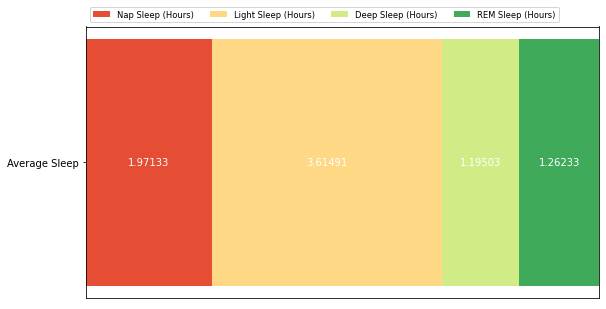

In [30]:
nap_avg = sleep_hw_df['Nap Sleep'].mean()
light_avg = sleep_hw_df['Light Sleep'].mean()
deep_avg = sleep_hw_df['Deep Sleep'].mean()
rem_avg = sleep_hw_df['REM Sleep'].mean()
sleep_categories = ['Nap Sleep (Hours)', 'Light Sleep (Hours)', 'Deep Sleep (Hours)', 'REM Sleep (Hours)']
results = [nap_avg, light_avg, deep_avg, rem_avg]

u.banded_bars(categories=sleep_categories, cat_label='Average Sleep', results=results)

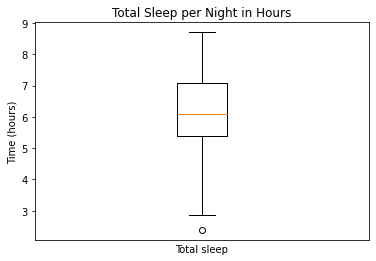

In [31]:
sleep_ser = sleep_hw_df['Total Sleep']
u.box_and_whisker(sleep_ser, y_label='Time (hours)', x_label='Total sleep', title='Total Sleep per Night in Hours')

This graph represents total sleep frequencies. 

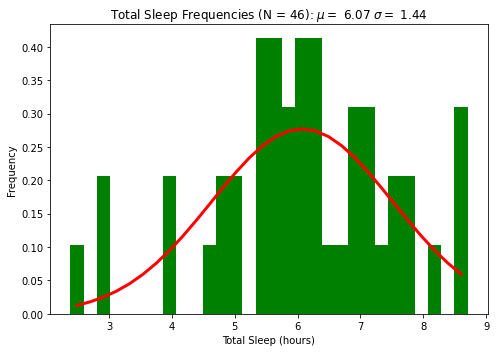

In [32]:
u.hist_trend(sleep_ser, x_label='Total Sleep (hours)', y_label='Frequency', title='Total Sleep Frequencies')

This is the same visualization from above for a period of a year instead of just the semester. We see that the mean is considerably higher, indicating a decline in sleep once the semester began. 

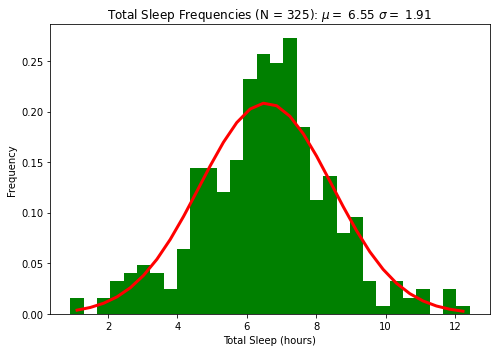

In [33]:
total_sleep_ser = whoop_df['Total Sleep']
u.hist_trend(total_sleep_ser, x_label='Total Sleep (hours)', y_label='Frequency', title='Total Sleep Frequencies')

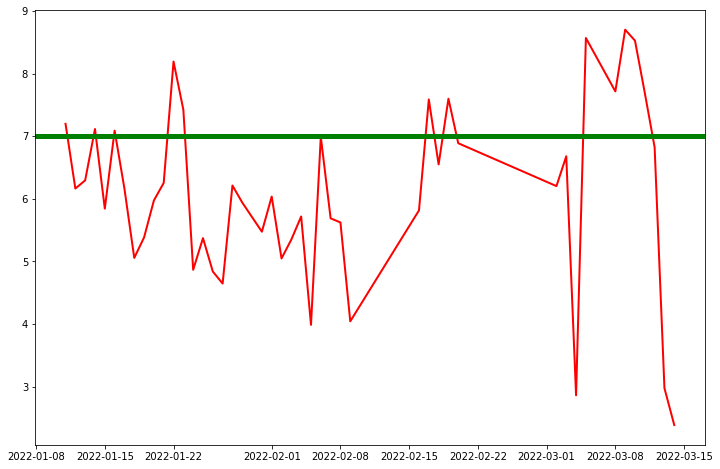

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(sleep_ser, color='red', lw=2)
ax.axhline(y=7, color='green', lw=5)

### Hypothesis Testing

We performed the following hypothesis tests:
1. first
2. second
3. third

## Classification Results

kNN

In [35]:
data = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Day of Week'], inplace=False)
test_case = [0.4, 4, 2, 0.6, 7, 2]
result = u.train_test(data, test_case=test_case, label='Weekday')
result_key = {0: "Test case is a Weekend", 1: "Test case is a Weekday"}
print(result_key[result[0]])

[0.15321083 1.32462278 1.50243306 0.378085   2.38641361 0.        ]
[2.08347194 5.72765944 2.41719024 2.16314167 8.70394472 3.        ]
[1]
Test case is a Weekday


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [36]:
data = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Weekday'], inplace=False)
print(data.columns)
test_case = [0.2, 2, 2, 0.3, 4.5, 0]
result = u.train_test(data, test_case=test_case, label='Number of Assignments')
#result_key = {0: "Test case is a Weekend", 1: "Test case is a Weekday"}
print(f'Predicted number of assignments: {result[0]}')


Index(['Deep Sleep', 'Light Sleep', 'Nap Sleep', 'REM Sleep', 'Total Sleep',
       'Number of Assignments', 'Day of Week'],
      dtype='object')
[0.15321083 1.32462278 1.50243306 0.378085   2.38641361 0.        ]
[2.08347194 5.72765944 2.41719024 2.16314167 8.70394472 6.        ]
[1.]
Predicted number of assignments: 1.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Decision Tree

In [37]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data = sleep_hw_df.drop(columns=['Deep Sleep Percent', 'Light Sleep Percent', 'Nap Count', 'REM Sleep Percent', 'Day of Week'], inplace=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# plt.figure(figsize=(10, 6))
# plt.plot(X_test, "b")
# plt.scatter(X_train, y_train, c="b", s=20)
# plt.plot(X_test, reg_tree_pred, "g", lw=2)
# plt.xlim([-5, 5])
# plt.title(
#     "Decision tree regressor, MSE = %.2f"
#     % (np.sum((y_test - reg_tree_pred) ** 2) / n_test)
# )
# plt.show()

## Conclusion

#### Summary

#### Classification Techniques

The classification approach you developed, your classifiers’ performance, and any ideas you have on ways to improve performance. 

#### Impact

Describe the potential impacts of your work (including ethical impacts) for the stakeholder’s you described in the introduction.